# Feature selection

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('customer_final.csv', low_memory=False)

In [5]:
df = df.drop(['Description', 'InvoiceDate', 'Desciption_c'], axis = 1)
y = df['churn']
df = df.drop(['churn'], axis = 1)

## Chi squared

In [34]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
X_norm = MinMaxScaler().fit_transform(df)
chi_selector = SelectKBest(chi2, k=5)
chi = chi_selector.fit_transform(X_norm, y)

In [35]:
chi_scores = chi2(X_norm,y)
chi_scores = pd.Series(chi_scores[0], index=df.columns)
chi_scores.plot()

(array([3.68263383e+01, 3.68263383e+01, 3.68263383e+01, ...,
        7.19586578e-03, 1.52466578e+01, 2.69664993e+01]),
 array([1.29133857e-09, 1.29133857e-09, 1.29133857e-09, ...,
        9.32397776e-01, 9.43435568e-05, 2.07012467e-07]))

In [ ]:
chi_scores.nlargest(10)

## Mutual information

In [14]:
from sklearn.feature_selection import mutual_info_classif
mi_score = mutual_info_classif(df,y)
print(mi_score)

[0.02239248 0.02496841 0.02255147 ... 0.01563719 0.09827132 0.10094505]


<AxesSubplot: >

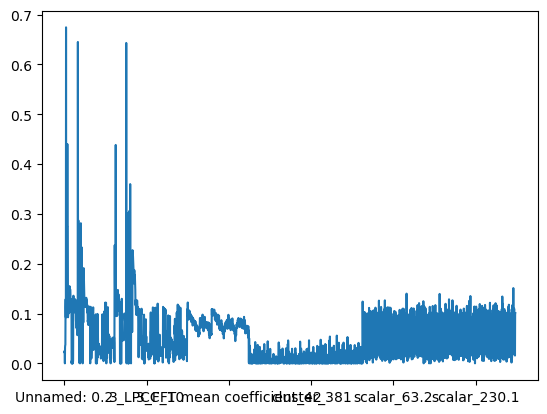

In [15]:
mi_scores = pd.Series(mi_score, index=df.columns)
mi_scores.plot()

In [36]:
mi_scores.nlargest(10)

Time since last purchase    0.674505
0_Max                       0.645118
2_Max                       0.643136
0_ECDF Percentile_1         0.440102
2_ECDF Percentile_1         0.438387
2_Spectral distance         0.359781
2_Root mean square          0.305684
2_Mean                      0.301861
0_Mean                      0.286915
0_Root mean square          0.281231
dtype: float64

## Fisher score

In [21]:
from skfeature.function.similarity_based import fisher_score
score_fisher = fisher_score.fisher_score(df.to_numpy(), y.to_numpy())

<AxesSubplot: >

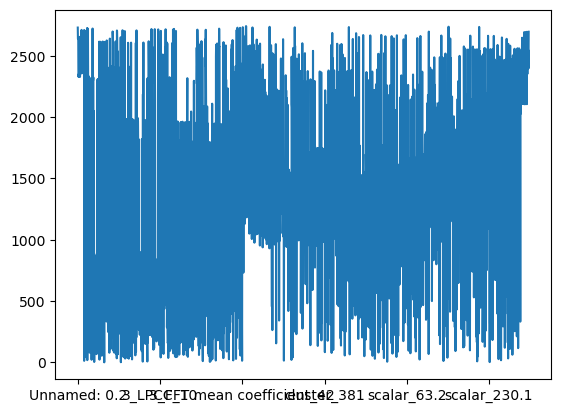

In [22]:
score_fisher = pd.Series(score_fisher, index=df.columns)
score_fisher.plot()

In [39]:
score_fisher.nlargest(10)

3_FFT mean coefficient_66    2741
3_FFT mean coefficient_64    2740
3_FFT mean coefficient_65    2739
scalar_148.1                 2738
cluster_45                   2737
scalar_210.1                 2736
cluster_533                  2735
3_FFT mean coefficient_45    2734
cluster_199                  2733
4_FFT mean coefficient_29    2732
dtype: int32

## RFE

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000000), n_features_to_select=1, step=1, verbose=-1)
rfe_selector.fit_transform(X_norm, y)


KeyboardInterrupt



necessary debugging to work with models

In [27]:
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

In [28]:
pd.options.mode.use_inf_as_na = True

df.fillna(df.max(),inplace=True)

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
embeded_rf_selector.fit(df, y)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

## Extra tree classifier

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(ExtraTreesClassifier(n_estimators = 10))
sel.fit(df, y)
sel.get_support()

array([ True, False,  True, ..., False, False,  True])

## Lasso feature selection

In [40]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(df, y)
# perform feature selection
kept_cols = [feature for feature, weight in zip(df.columns.values, lasso.coef_) if weight != 0]
len(kept_cols)

#if needed to save the list of features
#import json
#with open('test.txt', 'w') as f:
 #   f.write(json.dumps(kept_cols))

C:\Users\amosc\anaconda3\envs\cv3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+02, tolerance: 1.415e-01
  model = cd_fast.enet_coordinate_descent(


354

## Random forest classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
perm = PermutationImportance(rf, random_state=42).fit(X, y)
eli5.show_weights(perm, features_names=df.columns)


KeyboardInterrupt



## RANDOM FOREST EMBEDDED

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(df.shape[1]), importances[indices],
        color="lightsalmon", align="center")
plt.xticks(range(df.shape[1]), df.columns[indices], rotation=90)
plt.xlim([-1, df.shape[1]])
plt.show()